In [1]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt
from brainpy._src.integrators import JointEq
from brainpy._src.context import share
import jax
import jax.numpy as jnp
bp.math.set_dt(0.05)

In [2]:
import brainpy
brainpy.__version__

'2.6.0'

In [43]:
class A2(bp.neurons.HH):
    def __init__(self, size, ENa=120., EK=-12., EL=10.6, C=1.0, gNa=120.,
               gK=36, gL=0.3, V_th=0., method='exp_auto'):
        super().__init__(size=size, method=method)
        self.size = size

        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th

        # self.input = bm.Variable(bm.ones(size) * 9)
        self.input = bm.random.uniform(9.0,10.0,200)
        self.t_last_spike = bm.Variable(bm.ones(size) * -1e7)

    def dm(self, m, t, V):
        alpha =  0.1*(25-V) / (bm.exp(2.5 - 0.1*V)-1) #0.1 * (25-V) / (bm.exp(-0.1 * (V - 25)) - 1)
        beta = 4.0*bm.exp(-V/18.0) # 4 * bm.exp(-V / 18)
        dmdt = alpha * (1 - m) - beta * m
        return dmdt

    def dn(self, n, t, V):
        alpha = 0.01*(10.0-V)/ (bm.exp(1.0-0.1*V )-1) #0.01 * (10-V) / (bm.exp(0.1 * (10-V)) - 1)
        beta = 0.125*bm.exp(-V/80.0) #0.125 * bm.exp(-V / 80)
        dndt = alpha * (1 - n) - beta * n
        return  dndt

    def dh(self, h, t, V):
        alpha = 0.07*bm.exp(-V/20.0) #0.07 * bm.exp(-V / 20)
        beta = 1/(1+bm.exp(3.0-0.1*V)) #1 / (bm.exp(0.1 * (-V + 30)) + 1)
        dhdt = alpha * (1 - h) - beta * h
        return dhdt

    def dV(self, V, t, m, h, n, I):
        INa = self.gNa * m ** 3 * h * (V - self.ENa)
        IK = self.gK * n ** 4 * (V - self.EK)
        IL = self.gL * (V - self.EL)
        dVdt = (- INa - IK - IL + I) / self.C
        return dVdt

    @property
    def derivative(self):
        return JointEq(self.dV, self.dm, self.dh, self.dn)  # , self.dh, self.dn, self.ds, self.dc, self.dq)
    

    def update(self,x=None):
        t = share.load('t')
        dt = share.load('dt')
        print('x=', x)
        x = self.input if x is None else x
        print('after=', x)
       

        V, m, h, n = self.integral(self.V.value, self.m.value, self.h.value, self.n.value, t, x, dt)
        V  += self.sum_delta_inputs()
        self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
        self.V.value = V
        self.m.value = m
        self.h.value = h
        self.n.value = n
        # return self.spike.value


In [44]:
# issue with input 

In [45]:
class BaseAMPASyn(bp.dyn.SynConn):
    def __init__(self, pre, post, conn, delay=0, g_max=0.001, E=20, alpha=0.98,
               beta=0.18, 
               T=1, T_duration=1, perturbation_amplitude = 2.5,perturbation_interval=14.0, pulse_width=1.0,method='exp_auto'):
        super(BaseAMPASyn, self).__init__(pre=pre, post=post, conn=conn)

        # check whether the pre group has the needed attribute: "spike"
        self.check_pre_attrs('spike')

        # check whether the post group has the needed attribute: "input" and "V"
        self.check_post_attrs('input', 'V')

        # parameters
        self.delay = delay
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.T_duration = T_duration

        # use "LengthDelay" to store the spikes of the pre-synaptic neuron group
        self.delay_step = int(delay/bm.get_dt())
        self.pre_spike = bm.LengthDelay(pre.spike, self.delay_step)

        # store the arrival time of the pre-synaptic spikes
        self.spike_arrival_time = bm.Variable(bm.ones(self.pre.num) * -1e7)

        # integral function
        self.integral = bp.odeint(self.derivative, method=method)
        self.perturbation_amplitude = perturbation_amplitude
        self.perturbation_interval = perturbation_interval
        self.pulse_width = pulse_width

    def derivative(self, g, t, TT):
        dg = self.alpha * TT * (1 - g) - self.beta * g
       
        #dg =  (-self.beta * g + self.alpha *TT*((1-g)*5)/(1+bm.exp(-(self.pre.V+3)/8)))  # according to paper 
        #dg =  (-g + TT*((1-g)*5)/(1+bm.exp(-(self.pre.V+3)/8))) #this also works
        
        return dg
    
    
    def generate_perturbation(self, t):
        phase = t % self.perturbation_interval
        return self.perturbation_amplitude * bm.less(phase, self.pulse_width)
    
   

In [46]:
class AMPAAll2All(BaseAMPASyn):
  def __init__(self, *args, **kwargs):
    super(AMPAAll2All, self).__init__(*args, **kwargs)
    # connection matrix
    self.conn_mat = self.conn.require('conn_mat').astype(float)
    self.g = bm.Variable(bm.zeros((self.pre.num, self.post.num)))
    
    

  def update(self, x=None):
    _t, _dt = bp.share['t'], bp.share['dt']
    delayed_spike = self.pre_spike(self.delay_step)
    self.pre_spike.update(self.pre.spike)
    self.spike_arrival_time.value = bm.where(delayed_spike, _t, self.spike_arrival_time)
    TT = ((_t - self.spike_arrival_time) < self.T_duration) * self.T
    
    TT = TT.reshape((-1, 1))* self.conn_mat
    
    self.g.value = self.integral(self.g, _t, TT, dt=_dt)
    
    g_post = self.g.sum(axis=0)
    # it will let it access values of pulsed current 
    # (18000) time steps.. 18000 values for pulsed current ( repeating every 14 steps) 
    perturbation = self.generate_perturbation(_t)
    self.post.input += self.g_max * g_post *(self.E - self.post.V)  + perturbation
    # print('shape=', jax.eval_shape(perturbation))
    # print('time=', jax.ShapeDtypeStruct(perturbation,jnp.float32).shape)
    # print(jax.device_get(perturbation)) #.numpy())

    

In [47]:
num = 200
neu1 = A2(num)
neu1.V[:] = -70. + bm.random.normal(size=num) * 20 #*10

  0%|          | 0/18000 [00:00<?, ?it/s]

x= None
after= Variable(value=Traced<ShapedArray(float32[200])>with<DynamicJaxprTrace(level=2/0)>, dtype=float32)
x= None
after= Variable(value=Traced<ShapedArray(float32[200])>with<DynamicJaxprTrace(level=1/0)>, dtype=float32)


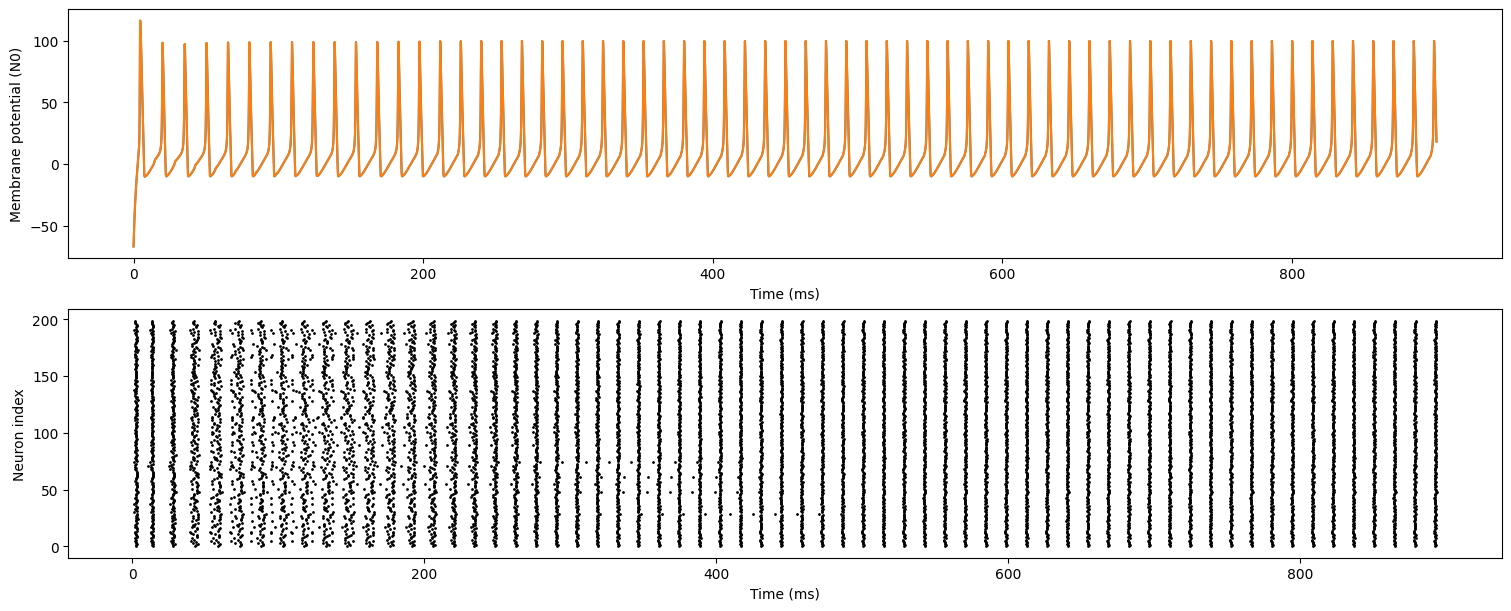

In [48]:
# Random network connectivity
conn = bp.connect.FixedProb(prob=0.5, include_self=False) # 10% connection probability, adjust as needed
syn = AMPAAll2All(pre=neu1, post=neu1, conn=conn) #ExpAll2All(pre=neu, post=neu, conn=conn)

#AMPAAll2All(pre=neu, post=neu, conn=conn)

# Random input currents
input_currents =  bm.random.uniform(9.0, 10.0, num) 

net = bp.Network(neu=neu1, syn=syn)
runner = bp.DSRunner(net, monitors=['neu.spike', 'neu.V','syn.g'], inputs=['neu.input', input_currents])

runner.run(duration=900.) 

fig, gs = bp.visualize.get_figure(2, 1, 3, 15)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'], ylabel='Membrane potential (N0)')
bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'])

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['neu.spike'], show=True)
plt.show()

In [ ]:
# Basic Model to define the AMPA synapse model. This class 
# defines the basic parameters, variables, and integral functions. 


class BaseAMPASyn(bp.SynConn):
  def __init__(self, pre, post, conn, delay=0., g_max=0.42, E=0., alpha=0.98,
               beta=0.18, T=0.5, T_duration=0.5, method='exp_auto'):
    super(BaseAMPASyn, self).__init__(pre=pre, post=post, conn=conn)

    # check whether the pre group has the needed attribute: "spike"
    self.check_pre_attrs('spike')

    # check whether the post group has the needed attribute: "input" and "V"
    self.check_post_attrs('input', 'V')

    # parameters
    self.delay = delay
    self.g_max = g_max
    self.E = E
    self.alpha = alpha
    self.beta = beta
    self.T = T
    self.T_duration = T_duration

    # use "LengthDelay" to store the spikes of the pre-synaptic neuron group
    self.delay_step = int(delay/bm.get_dt())
    self.pre_spike = bm.LengthDelay(pre.spike, self.delay_step)

    # store the arrival time of the pre-synaptic spikes
    self.spike_arrival_time = bm.Variable(bm.ones(self.pre.num) * -1e7)

    # integral function
    self.integral = bp.odeint(self.derivative, method=method)

  def derivative(self, g, t, TT):
    dg = self.alpha * TT * (1 - g) - self.beta * g
    return dg

In [ ]:
class AMPAConnMat(BaseAMPASyn):
  def __init__(self, *args, **kwargs):
    super(AMPAConnMat, self).__init__(*args, **kwargs)

    # connection matrix
    self.conn_mat = self.conn.require('conn_mat').astype(float)

    # synapse gating variable
    # -------
    # NOTE: Here the synapse shape is (num_pre, num_post),
    #       in contrast to the ExpConnMat
    self.g = bm.Variable(bm.zeros((self.pre.num, self.post.num)))

  def update(self, tdi, x=None):
    _t, _dt = tdi.t, tdi.dt
    # pull the delayed pre spikes for computation
    delayed_spike = self.pre_spike(self.delay_step)
    # push the latest pre spikes into the bottom
    self.pre_spike.update(self.pre.spike)
    # get the time of pre spikes arrive at the post synapse
    self.spike_arrival_time.value = bm.where(delayed_spike, _t, self.spike_arrival_time)
    # get the neurotransmitter concentration at the current time
    TT = ((_t - self.spike_arrival_time) < self.T_duration) * self.T
    # integrate the synapse state
    TT = TT.reshape((-1, 1)) * self.conn_mat  # NOTE: only keep the concentrations
                                              #       on the invalid connections
    self.g.value = self.integral(self.g, _t, TT, dt=_dt)
    # get the post-synaptic current
    g_post = self.g.sum(axis=0)
    self.post.input += self.g_max * g_post * (self.E - self.post.V)

In [ ]:
# def show_syn_model(model):
pre = bp.neurons.LIF(10, V_rest=-60., V_reset=-60., V_th=-40.)
post = bp.neurons.LIF(10, V_rest=-60., V_reset=-60., V_th=-40.)
syn = AMPAConnMat(pre, post, conn=bp.conn.One2One())
net = bp.Network(pre=pre, post=post, syn=syn)

runner = bp.DSRunner(net,
                   monitors=['pre.V', 'post.V', 'syn.g'],
                   inputs=['pre.input', 22.])
runner.run(100.)

fig, gs = bp.visualize.get_figure(1, 2, 3, 4)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon['syn.g'], legend='syn.g')
fig.add_subplot(gs[0, 1])
bp.visualize.line_plot(runner.mon.ts, runner.mon['pre.V'], legend='pre.V')
bp.visualize.line_plot(runner.mon.ts, runner.mon['post.V'], legend='post.V', show=True)

In [ ]:
syn.g[150,150] = 0 
syn.g[160,160]=0

In [ ]:
bp.visualize.line_plot(runner.mon.ts, runner.mon['syn.g'], legend='syn.g')

In [ ]:
runner.mon['syn.g'].shape

In [ ]:
show_syn_model(AMPAConnMat)

In [ ]:
np.max(runner.mon['syn.g'])

In [ ]:
runner.mon['syn.g'][:,47].flatten()[1800000:].shape, runner.mon.ts.shape

In [ ]:
bp.visualize.raster_plot(runner.mon.ts, runner.mon['syn.g'][:,47][180000:].flatten(), show=True)

In [ ]:
# possible reason this is not coming ... 
#synchronisation is not visible in continuous pulse for this case ☹️
# yahan pe conductance ki value zero kyu aa rahi hai 

In [50]:
class AMPA(bp.Projection):
    def __init__(self, pre, post, delay, prob, g_max, E=0.):
        super().__init__()
        self.proj = bp.dyn.ProjAlignPreMg2(
          pre=pre, 
          delay=delay, 
          syn=bp.dyn.AMPA.desc(pre.num, alpha=0.98, beta=0.18, T=0.5, T_dur=0.5),
          comm=bp.dnn.CSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
          out=bp.dyn.COBA(E=E),
          post=post, 
        )

In [ ]:
class SimpleNet(bp.DynSysGroup):
    def __init__(self, E=20.):
        super().__init__()
        self.neu =  A2(200) #neu1 
        # perturbation_amplitude = 2.50
        prob = 0.5
        conn = bp.connect.FixedProb(prob=prob, include_self=False)
        # self.syn =  bp.synapses.GABAa(neu1, neu1, bp.conn.FixedProb(0.5),
        #          output=bp.synouts.COBA(E=20.),
                 # alpha=0.98, beta=0.18, g_max=0.001)
        #bp.synapses.GABAa(pre=self.neu, post=self.neu, conn=conn, output=bp.synouts.COBA(E=20),alpha=0.98, beta= 0.18, stop_spike_gradient=False) 
        # self.syn = AMPAAll2All(pre=self.neu, post=self.neu, conn=bp.connect.FixedProb(prob=prob, include_self=False)) #, E=E,perturbation_amplitude=perturbation_amplitude)
        self.syn = AMPA(self.neu, self.neu, delay=0, prob=0.5, g_max = 0.001, E=20) #
        #bp.synapses.AMPA(pre=self.neu, post=self.neu, conn=bp.connect.All2All(include_self=True),stop_spike_gradient=False)#GABAa(self.pre,self.post, delay=0, prob=1., g_max=0.1/100, E=-75.)
        # shape = (100,100)
        # self.syn.g_max= bp.init.Normal(mean=0.1, scale=0.02)(shape)/100 ##0.1/100
        
    def update(self,I_pre):
        self.neu(I_pre) #.update(I_pre)
        self.syn()

        # conductance =  self.syn.g#self.syn.proj.refs['syn'].g
        conductance =  self.syn.proj.refs['syn'].g
        current = self.neu.sum_inputs(self.neu.V)
        return conductance, current, self.neu.V,self.neu.spike.value


    
    

# def run_simulation(E,prob,perturbation_amplitude):
# net = SimpleNet()
# runner = bp.DSRunner(net, monitors=['syn.g'])
# conductances, currents, potentials, spikes = runner.run(duration=1000)

# fig, gs = bp.visualize.get_figure(1, 1, 3, 8)
# fig.add_subplot(gs[0, 0])
# bp.visualize.raster_plot(runner.mon.ts, spikes, show=True)
# plt.show()

In [ ]:
bp.visualize.line_plot(runner7.mon.ts, runner7.mon['syn.g'], legend='syn.g')

In [80]:
duration = 900
I_pre = bp.inputs.square_input(amplitude=2.5, frequency=71.43,
                                  duration=duration, t_start=0)

In [ ]:
net = SimpleNet(E=20)
# def run(i, I_pre):
#     g, current, pot, spk = net.step_run(i, I_pre)
#     return  g, current, pot, spk

indices = bm.arange(0, duration, bm.dt)
# g,current,pot,spk = bm.for_loop(run, [indices, I_pre])

In [ ]:
runner7.mon['syn.g'].shape

In [ ]:
# still all values for conductance are zero ☹️☹️☹️

In [ ]:

runner7 = bp.DSRunner(target=SimpleNet(E=20),
                      monitors=['neu.spike','syn.g'],
                      inputs=[('neu.input', I_pre, 'iter')],  # iterable inputs
                      jit=True)
runner7.run(900)
bp.visualize.raster_plot(runner7.mon.ts, runner7.mon['neu.spike'])

In [ ]:
runner3.mon['V'][:,1].shape

In [ ]:
bp.visualize.raster_plot(runner3.mon.ts, runner3.mon['V'][:,1:5])

In [81]:
neu1 = A2(200)
# neu2 = A2(200)
syn1 = AMPA(neu1, neu1,  delay=0, prob=0.2, g_max = 0.001, E=20)
# net = bp.DynSysGroup(pre=neu1, syn=syn1, post=neu2)
net = bp.DynSysGroup(neu=neu1, syn=syn1) #, post=neu2)

/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.dyn.ProjAlignPreMg2 is deprecated. Use brainpy.dyn.FullProjAlignPreDSMg instead.
  _deprecate(message)


In [82]:
runner3 = bp.DSRunner(target=net,
                      monitors={'spike': neu1.spike, 'V': neu1.V,'syn.g': syn1.proj.refs['syn'].g},
                      inputs=[(neu1.input, I_pre,'iter')],#,(neu2.input, I_pre,'iter')],
                      jit=True)
runner3.run(100.)

  0%|          | 0/2000 [00:00<?, ?it/s]

x= None
after= Variable(value=Traced<ShapedArray(float32[200])>with<DynamicJaxprTrace(level=2/0)>, dtype=float32)
x= None
after= Variable(value=Traced<ShapedArray(float32[200])>with<DynamicJaxprTrace(level=1/0)>, dtype=float32)


In [83]:
#net = SimpleNet(E=20)
runner3 = bp.DSRunner(target=net,
                      monitors={'spike': neu1.spike, 'V': neu1.V,'syn.g': syn1.proj.refs['syn'].g,'input':neu1.input},
                      inputs=(neu1.input, I_pre,'iter'),
                      jit=True)
runner3.run(900.)

  0%|          | 0/18000 [00:00<?, ?it/s]

x= None
after= Variable(value=Traced<ShapedArray(float32[200])>with<DynamicJaxprTrace(level=2/0)>, dtype=float32)
x= None
after= Variable(value=Traced<ShapedArray(float32[200])>with<DynamicJaxprTrace(level=1/0)>, dtype=float32)


In [76]:
len(np.where(I_pre==1)[0])

9040

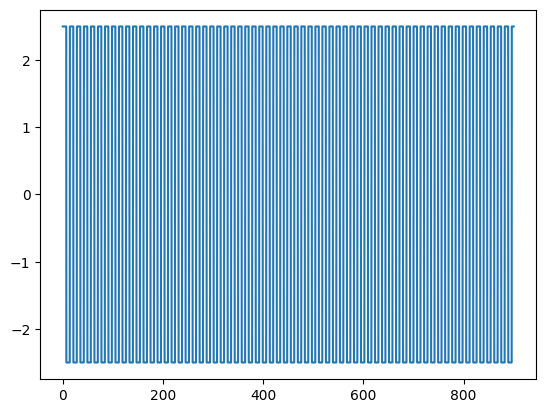

In [84]:
# current to theek hai 
plt.plot(runner3.mon.ts, runner3.mon['input'][:,0], label='g')

In [85]:
runner3.mon['input'][:,0].shape

(18000,)

In [86]:
import numpy as np
len(np.where(runner3.mon['input'][:,0]==1)[0])

0

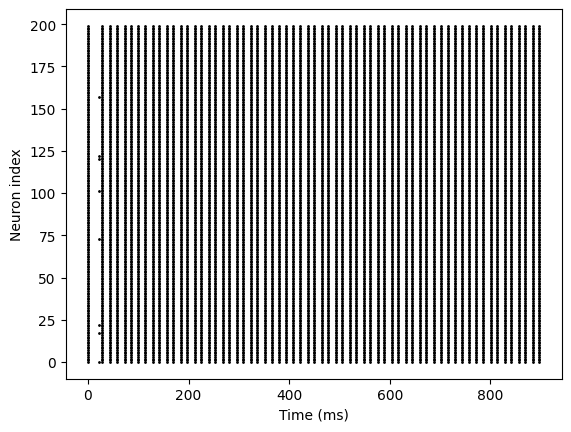

In [87]:
bp.visualize.raster_plot(runner3.mon.ts, runner3.mon['spike'], show=True)

In [ ]:
import matplotlib.pyplot as plt

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
fig.add_subplot(gs[0, 0])
# plt.plot(runner3.mon.ts, runner3.mon['V'][:,0], label='pre-V')
plt.plot(runner3.mon.ts, runner3.mon['spike'][:,1:2], label='post-V')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(runner3.mon.ts, runner3.mon['syn.g'][:,0], label='g')
plt.legend()
plt.show()

In [ ]:
def run_a_net(net, duration=100):
    def run(i, I_pre):
        g, current, pot, spk = net.step_run(i, I_pre)
        return  g, current, pot, spk
  
    conductances, currents, potentials,spks = bm.for_loop(run, [indices,I_pre], progress_bar=True)
    ts = indices * bm.get_dt()

    # --- similar to: 
    # runner = bp.DSRunner(net)
    # conductances, currents, potentials = runner.run(100.)

    fig, gs = bp.visualize.get_figure(1, 3, 3.5, 4)
    fig.add_subplot(gs[0, 0])
    plt.plot(ts, conductances[:,0])
    plt.title('Syn conductance')
    fig.add_subplot(gs[0, 1])
    plt.plot(ts, currents)
    plt.title('Syn current')
    fig.add_subplot(gs[0, 2])
    plt.plot(ts, potentials)
    plt.title('Post V')
    plt.show()


In [ ]:
run_a_net(SimpleNet(E=20)).conductances.shape

In [ ]:
run_a_net(SimpleNet(E=20))

In [ ]:
fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts,g[:, 0], label='Neuron 0')
# bp.visualize.line_plot(runner.mon.ts, potentials[:, 1],label='Neuron 0')

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts, spk, show=True)
plt.show()

In [ ]:
net = SimpleNet(E=20.)
runner = bp.DSRunner(net)
conductances, currents, potentials, spikes = runner.run(duration=1000)


fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, conductances[:, 0], label='Neuron 0')
# bp.visualize.line_plot(runner.mon.ts, potentials[:, 1],label='Neuron 0')

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts, spikes, show=True)
plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display

In [ ]:
def run_simulation(E,prob,perturbation_amplitude):
    # Reset the network and runner
    neu = A2(num)
    neu.V[:] = -70. + bm.random.normal(size=num) * 20*10
    conn = bp.connect.FixedProb(prob=prob, include_self=False)
    syn = AMPAAll2All(pre=neu, post=neu, conn=conn, E=E,perturbation_amplitude=perturbation_amplitude)
    net = bp.Network(neu=neu, syn=syn)
    runner = bp.DSRunner(net, monitors=['neu.spike', 'neu.V'], inputs=['neu.input', input_currents])
    
    runner.run(duration=900.)
    
    fig, gs = bp.visualize.get_figure(2, 1, 3, 15)
    
    fig.add_subplot(gs[0, 0])
    bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'], ylabel='Membrane potential (N0)')
    
    fig.add_subplot(gs[1, 0])
    bp.visualize.raster_plot(runner.mon.ts, runner.mon['neu.spike'], show=False)
    plt.show()

In [ ]:
E_slider = widgets.IntSlider(
    value=20,
    min=-100,
    max=100,
    step=5,
    description='E:',
    continuous_update=False
)

prob_slider = widgets.FloatSlider(
    value=0.5, 
    min=0.0, max=1.0, 
    step=0.1, 
    description='Prob:',
    continuous_update=False)

Perturbation_slider = widgets.FloatSlider(
    value=2.5,
    min=0,
    max=10,
    step=0.5,
    description='Perturb:',
    continuous_update=False
)

widgets.interactive(run_simulation, E=E_slider,prob=prob_slider, perturbation_amplitude=Perturbation_slider)

phase= Array(value=Array([1., 1., 1., ..., 0., 0., 0.]), dtype=float32)


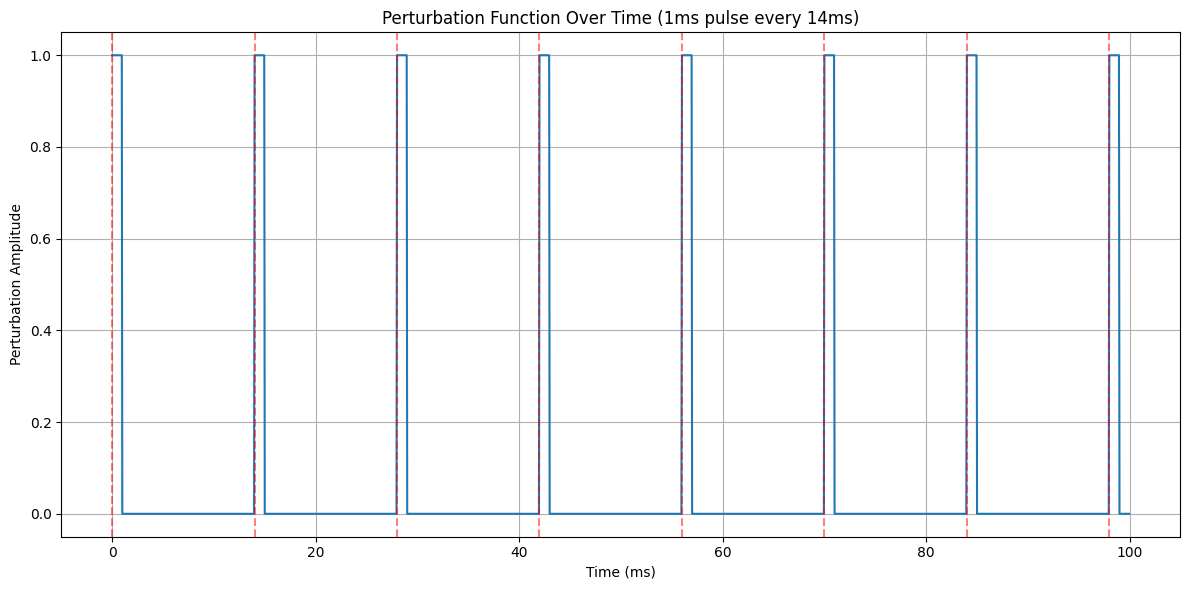

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def generate_perturbation(t, perturbation_amplitude=1.0, interval=14.0, pulse_width=1.0):
    # Calculate the phase within each interval
    phase = t % interval
    
    print('phase=', perturbation_amplitude * bm.less(phase, pulse_width))
    
    # Create a pulse that's high for pulse_width ms at the start of each interval
    
    return perturbation_amplitude * bm.less(phase, pulse_width)

# Create a time array from 0 to 100 ms with 0.1 ms steps
t = np.arange(0, 100, 0.05)

# Calculate the perturbation values
perturbation = generate_perturbation(t, pulse_width=1.0)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(t, perturbation)
plt.title('Perturbation Function Over Time (1ms pulse every 14ms)')
plt.xlabel('Time (ms)')
plt.ylabel('Perturbation Amplitude')
plt.grid(True)

# Add vertical lines every 14 ms to highlight the periodicity
for i in range(0, 101, 14):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [99]:
generate_perturbation(14.05, pulse_width=1.0)

0.05000000000000071 14.05


Array(1., dtype=float32, weak_type=True)

In [ ]:
a =np.where(perturbation==1)
b = np.where(current9==1)
len(a[0]), len(set(a[0]).intersection(set(b[0])))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show(current, duration, title):
    ts = np.arange(0, duration, bm.get_dt())
    plt.plot(ts, current)
    plt.title(title)
    plt.xlabel('Time [ms]')
    plt.ylabel('Current Value')
    plt.show()
duration = 900
current9 = bp.inputs.square_input(amplitude=1., frequency=71.43,
                                  duration=duration, t_start=0)
show(current9, duration, 'Square Input')

In [ ]:
n_step_per_monitor = 10
indices = np.arange(10000).reshape(-1, n_step_per_monitor)
inputs = np.ones(indices.shape) * 20.
inputs.shape

In [ ]:
np.ones(200)*current9

In [ ]:
(input_currents[0] + current9).shape

In [ ]:
show(input_currents[:200], duration, 'Square Input')

In [ ]:
np.where(perturbation==1)[0][:60]

In [ ]:
perturbation[:100]